In [69]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [12]:
blocks = pl.read_parquet('dude_data/blocks.parquet')
txs = pl.read_parquet('dude_data/txs.parquet').drop(['locktime'])
inputs = pl.read_parquet('dude_data/inputs.parquet')
outputs = pl.read_parquet('dude_data/outputs.parquet').drop(['script_size'])

In [13]:
blocks

block_id,block,timestamp,n_txs
str,i64,"datetime[μs, UTC]",i64
"""00000000000000000001a80ff6a5bb…",896334,2025-05-12 00:40:59 UTC,2672
"""000000000000000000020f4e0c2902…",896335,2025-05-12 01:14:19 UTC,3198
"""000000000000000000023aa96068b5…",896336,2025-05-12 01:21:08 UTC,3999
"""000000000000000000018c79254db4…",896337,2025-05-12 01:35:53 UTC,3884
"""000000000000000000010481d78804…",896338,2025-05-12 01:36:30 UTC,1252
…,…,…,…
"""0000000000000000000042ba25df6a…",896401,2025-05-12 11:32:18 UTC,546
"""00000000000000000000b28ecdd373…",896402,2025-05-12 11:41:17 UTC,2531
"""000000000000000000016f23b31869…",896403,2025-05-12 11:41:39 UTC,116


In [14]:
blocks.sum()['n_txs'][0] == txs.shape[0]

True

In [15]:
txs.sum()['n_inputs'][0] == inputs.shape[0]

True

In [16]:
txs.sum()['n_outputs'][0] == outputs.shape[0]

True

In [40]:
txs2 = (
    txs
    .with_columns(
        (pl.col('n_inputs') >= 6).alias('is_too_many_inputs'),
        (pl.col('n_outputs') >= 3).alias('is_too_many_outputs'),
        (pl.col('n_outputs') == 1).alias('is_one_output'),
        (pl.col('witness_size') > 500).alias('is_witness_too_big'),
    )
    .drop(['n_inputs', 'n_outputs', 'witness_size'])
    .join(outputs, on='txid', how='inner')
    .with_columns(
        (pl.col('amount') < 1000).alias('is_amount_too_small'),
        (pl.col('amount') >= 10e8).alias('is_amount_too_big'),
        # Check if amount is a power of 10
        (
            pl.when(pl.col('amount') <= 0)
            .then(False)
            .otherwise(pl.col('amount').log10())
            .alias('log10')
        )
    )
    .rename({'index': 'output_index'})
    .select(
        pl.col(['block', 'txid', 'amount', 'log10', 'output_index']),
        pl.col('^is_.*$')
    )
    .with_columns(
        pl.any_horizontal(pl.col('^is_.*$')).alias('exclude')
    )
)
txs2

block,txid,amount,log10,output_index,is_coinbase,is_too_many_inputs,is_too_many_outputs,is_one_output,is_witness_too_big,is_op_return,is_amount_too_small,is_amount_too_big,exclude
i64,str,i64,f64,i64,bool,bool,bool,bool,bool,bool,bool,bool,bool
896334,"""b92c03f30b602c9722e82220ddd023…",317858038,8.502233,0,true,false,false,false,false,false,false,false,true
896334,"""b92c03f30b602c9722e82220ddd023…",0,0.0,1,true,false,false,false,false,true,true,false,true
896334,"""50d1ae7f52a172fd4377849fd651b5…",231716,5.364956,0,false,false,false,false,false,false,false,false,false
896334,"""50d1ae7f52a172fd4377849fd651b5…",0,0.0,1,false,false,false,false,false,true,true,false,true
896334,"""8281d304e8737173c23e39fb544544…",231716,5.364956,0,false,false,false,false,false,false,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…
896405,"""0b8fad09919c56e6ea2e5753011f6e…",600,2.778151,7,false,false,true,false,false,false,true,false,true
896405,"""0b8fad09919c56e6ea2e5753011f6e…",600,2.778151,8,false,false,true,false,false,false,true,false,true
896405,"""0b8fad09919c56e6ea2e5753011f6e…",600,2.778151,9,false,false,true,false,false,false,true,false,true


In [70]:
txs2_nonzero = txs2.filter(pl.col('amount') > 0)
min_amount = txs2_nonzero['amount'].min()
max_amount = txs2_nonzero['amount'].max()
bins = np.logspace(np.log10(min_amount), np.log10(max_amount), num=50)

In [73]:
# Compute histogram manually
hist = (
    txs2_nonzero
    .filter(
        pl.col('amount') >= 10e8 # any 10+ BTC amount can be excluded 
    )
    .with_columns(
        pl.col('amount').cut(breaks=bins, include_breaks=True).alias('bin')
    )
    .group_by('bin')
    .agg(count=pl.len())
    .with_columns(
        pl.col('bin').struct.field('breakpoint').alias('breakpoint'),
        pl.col('count').fill_null(0)
    )
    .sort('breakpoint')
)

In [74]:
hist

bin,count,breakpoint
struct[2],u32,f64
"{1.0477e9,""(588400255.4573092, 1047695151.5307757]""}",402,1.0477e9
"{1.8655e9,""(1047695151.5307757, 1865507569.6525261]""}",1057,1.8655e9
"{3.3217e9,""(1865507569.6525261, 3321689985.2462926]""}",504,3.3217e9
"{5.9145e9,""(3321689985.2462926, 5914542796.596995]""}",499,5.9145e9
"{1.0531e10,""(5914542796.596995, 10531330933.39643]""}",730,1.0531e10
…,…,…
"{1.8849e11,""(105859926016.32751, 188492323380.3038]""}",9,1.8849e11
"{3.3563e11,""(188492323380.3038, 335626117552.97363]""}",7,3.3563e11
"{5.9761e11,""(335626117552.97363, 597609965029.7646]""}",3,5.9761e11


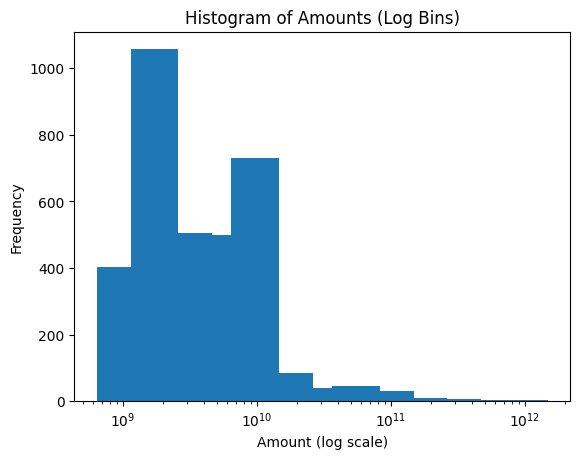

In [75]:
# Plot histogram with log scale
plt.bar(hist['breakpoint'][:-1], hist['count'][:-1], width=np.diff(hist['breakpoint']))
plt.xscale('log')
plt.xlabel('Amount (log scale)')
plt.ylabel('Frequency')
plt.title('Histogram of Amounts (Log Bins)')
plt.show()

In [76]:
outputs['amount'].describe()

statistic,value
str,f64
"""count""",461170.0
"""null_count""",0.0
"""mean""",7.4274e7
"""std""",4.9890e9
"""min""",0.0
"""25%""",850.0
"""50%""",56158.0
"""75%""",377366.0
"""max""",1.8947e12
